In [2]:
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator

In [39]:
ls

data_exp.ipynb*                    __init__.py*         thresh_losses.json*
equipment_failure_notebook.ipynb*  new_explore.ipynb*   Untitled.ipynb*
frag_tools.py*                     profit_curve.ipynb*
initial_data_cleaning.ipynb*       __pycache__/


In [43]:
from frag_tools import (DropColumns,
                        AddressLatLong,
                        CurrentMakeDummies,
                        Binarize,
                        ChangeTypes,
                        custom_zip_cleaning)
from src import various_tools

ImportError: cannot import name 'various_tools'

In [5]:
df = pd.read_csv('/mnt/c/Users/kurtrm/Downloads/Predictive_Maintenance_Transformer_Overload_PA.csv', sep=';')

In [7]:
pipe = make_pipeline(CurrentMakeDummies(['Manufacturer',
                                         'Repairs',
                                         'Overloads',
                                         'AssetType']),
                     ChangeTypes(['Age', 'AssetZip'],
                                 [lambda x: float(x.replace(',', '.')),
                                  custom_zip_cleaning]),
                     Binarize(['VegMgmt',
                               'PMLate',
                               'WaterExposure',
                               'MultipleConnects',
                               'Storm']),
                     AddressLatLong(),
                     DropColumns(['AssetCity',
                                  'AssetId',
                                  'AvgRepairCost',
                                  'AssetState',
                                  'MilesFromOcean',
                                  'AssetLocation',
                                  'locationID',
                                  'Latitude1',
                                  'Longitude1',
                                  'AssetZip']))
transformed = pipe.fit_transform(df)

In [8]:
transformed.head()

,VegMgmt,PMLate,WaterExposure,MultipleConnects,Storm,Age,Latitude,Longitude,Status,Manufacturer_GE,...,Repairs_Rebuild+3,Overloads_100-120%,Overloads_120-150%,Overloads_Above 150%,Overloads_Below 100%,AssetType_1-Phase Pole Transformer,AssetType_3-Phase Transformer,AssetType_DF-series Transformer,AssetType_Padmount Transformer,AssetType_Voltage Transformer
0,1,0,0,1,0,70.3,33.516805,-84.258478,1,0,...,1,0,0,0,1,1,0,0,0,0
1,1,0,0,0,0,70.3,33.959887,-84.435503,1,0,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,70.3,33.932735,-84.259163,0,0,...,0,0,0,1,0,1,0,0,0,0
3,1,0,0,1,0,70.3,33.555964,-84.257573,0,0,...,0,0,0,1,0,1,0,0,0,0
4,1,0,0,0,0,70.3,33.478919,-84.354102,0,0,...,0,0,0,1,0,1,0,0,0,0


In [13]:
# For later use
lat_longs_status = transformed[['Latitude', 'Longitude', 'Status']]

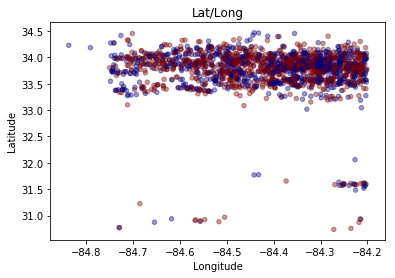

In [18]:
lat_longs_status.plot(kind='scatter', x='Longitude', y='Latitude', alpha=.4,
                      c='Status', cmap=plt.get_cmap("jet"), title='Lat/Long',
                      colorbar=False)

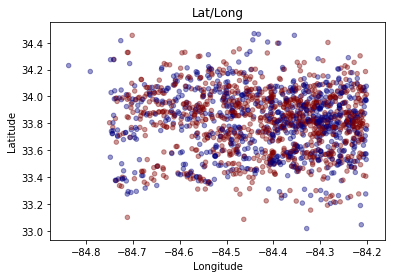

In [20]:
lat_longs_status[lat_longs_status['Latitude'] > 33].plot(kind='scatter', x='Longitude', y='Latitude', alpha=.4,
                      c='Status', cmap=plt.get_cmap("jet"), title='Lat/Long',
                      colorbar=False)

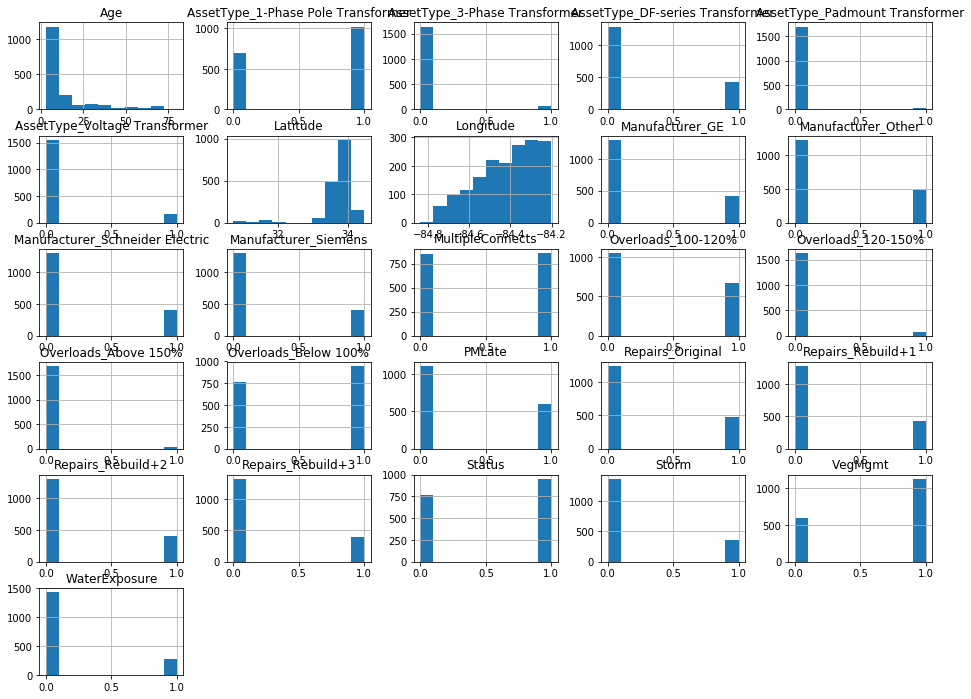

In [24]:
transformed.hist(figsize=(16, 12));

In [29]:
train, test = train_test_split(transformed, test_size=.2)
X_train, X_test, y_train, y_test = train_test_split(train.drop('Status', axis=1).values,
                               train['Status'].values, test_size=.2)